In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## Hyperparameters and Configuration

In [2]:
# Modified hyperparameters
SEQUENCE_LENGTH = 64

EMBEDDING_DIM = 64
HIDDEN_DIM = EMBEDDING_DIM*2

BATCH_SIZE = 512
EPOCHS = 20
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.1

NUM_LAYERS = 4
NUM_HEADS = 4
FFN_DIM = 256
DROPOUT = 0.1

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:1


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [3]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [4]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In [5]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [6]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

In [7]:
# Load the data
text = load_data('../data/input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003791
Validation dataset size: 111475


## Data Visualization

In [8]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([512, 64])
Target shape: torch.Size([512, 64])
Sample 1: ------------------------------
Input sequence : , be not angry with the child.QUEEN ELIZABETH:Pitchers have e
Target sequence:  be not angry with the child.QUEEN ELIZABETH:Pitchers have ea

Sample 2: ------------------------------
Input sequence : d.Nurse:JULIET:I come, anon.--But if thou mean'st not well,
Target sequence: .Nurse:JULIET:I come, anon.--But if thou mean'st not well,

Sample 3: ------------------------------
Input sequence : ord thitherHow the world goes, that to the pace of itI may spu
Target sequence: rd thitherHow the world goes, that to the pace of itI may spur



## Training Function

In [9]:
def print_vram_usage(device="cuda"):
    allocated = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
    reserved = torch.cuda.memory_reserved(device) / (1024**2)    # in MB
    max_allocated = torch.cuda.max_memory_allocated(device) / (1024**2)  # in MB
    print(f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB, Max Allocated: {max_allocated:.2f} MB")

In [10]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))
    return losses

In [11]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device, epoch, step):
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        step += 1
        losses.append((step, epoch, loss.item()))
        
        # VRAM 사용량을 progress bar의 postfix로 업데이트
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', step=step, vram=f'{allocated:.2f} MB')
    return losses, step, vram_usage

## Generation Function

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    all_train_losses = []
    all_val_losses = []
    all_vram_usages = []
    step = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        # Training phase with tqdm updates
        epoch_train_losses, step, vram_usage = train(model, train_loader, criterion, optimizer, device, epoch, step)
        all_train_losses.extend(epoch_train_losses)
        all_vram_usages.append(vram_usage)
        
        # Validation phase
        epoch_val_losses = validate(model, val_loader, criterion, device, epoch, step)
        all_val_losses.extend(epoch_val_losses)
        
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_train_losses[-1][2]:.4f}, '
              f'Val Loss: {epoch_val_losses[-1][2]:.4f}, Epoch Time: {epoch_time:.2f}s',
              f'Average Vram Usage: {np.mean(vram_usage):.2f}MB')

    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])
    # average_vram_usage = np.mean(all_vram_usages)
    return model, train_losses_df, val_losses_df


In [13]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, hidden = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [14]:
loss_comparison_dict = {}

def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

def print_final_losses(loss_dict):
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        val_df = losses['val']
        final_train = train_df.groupby('epoch')['loss_value'].last().iloc[-1]
        final_val = val_df.groupby('epoch')['loss_value'].last().iloc[-1]
        print(f"{model_name}: Final Train Loss: {final_train:.4f}, Final Val Loss: {final_val:.4f}")

In [15]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [16]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training loss curves and average validation loss per epoch for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))
    
    # Get the last model in the dictionary (for special final-point highlighting)
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name} train', linestyle='-', alpha=0.7)

        # Scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # Compute average validation loss per epoch (using the last step of each epoch for x-axis)
        avg_val_losses = val_losses_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        # Scatter the average validation loss for each epoch
        plt.scatter(avg_val_losses['step'], avg_val_losses['loss_value'], marker='s', s=50,
                    label=f'{model_name} val avg')

        # For the last model, highlight the final training loss with a star
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend shows both training and validation average labels
    plt.grid(True)
    plt.show()


In [17]:
def plot_separate_train_val(loss_dict):
    """
    모델별 Training Loss와 Validation Loss를 각각 별도의 그래프로 그립니다.
    단, Validation Loss는 에포크별 평균으로 계산합니다.
    """
    # 1. Training Loss Plot (원본 그대로)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        steps_train = train_df['step'].values
        loss_train = train_df['loss_value'].values
        plt.plot(steps_train, loss_train, label=f'{model_name} Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Validation Loss Plot (에포크별 평균 처리)
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    for model_name, losses in loss_dict.items():
        val_df = losses['val']
        # 에포크별 평균 loss와 마지막 step을 계산
        val_avg = val_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        plt.plot(val_avg['step'], val_avg['loss_value'], label=f'{model_name} Val')
    plt.title('Validation Loss (Epoch Avg) Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## Model 1: GRU Decoder

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRUDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.1):
        super(GRUDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, hidden=None):
        embed = self.embedding(x)
        output, hidden = self.gru(embed, hidden)
        output = self.dropout(output)
        output = self.layer_norm(output)
        output = F.gelu(self.fc1(output))
        output = self.fc2(output)
        return output, hidden

In [19]:
### Model Initialization
gru = GRUDecoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gru.parameters(), lr=LEARNING_RATE, fused=True)

In [20]:
from torchinfo import summary

summary(gru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
GRUDecoder                               [512, 64, 65]             --
├─Embedding: 1-1                         [512, 64, 64]             4,160
├─GRU: 1-2                               [512, 64, 128]            173,568
├─Dropout: 1-3                           [512, 64, 128]            --
├─LayerNorm: 1-4                         [512, 64, 128]            256
├─Linear: 1-5                            [512, 64, 128]            16,512
├─Linear: 1-6                            [512, 64, 65]             8,385
Total params: 202,881
Trainable params: 202,881
Non-trainable params: 0
Total mult-adds (G): 5.70
Input size (MB): 0.26
Forward/backward pass size (MB): 134.48
Params size (MB): 0.81
Estimated Total Size (MB): 135.55

In [21]:
## Training Loop
trained_model, train_losses_df, val_losses_df = train_model(gru, train_loader, val_loader, criterion, optimizer, device, EPOCHS)

Epoch 1/20, Train Loss: 1.7962, Val Loss: 1.8737, Epoch Time: 16.49s Average Vram Usage: 29.23MB


Epoch 2/20, Train Loss: 1.6203, Val Loss: 1.8200, Epoch Time: 16.55s Average Vram Usage: 29.23MB


Epoch 3/20, Train Loss: 1.5397, Val Loss: 1.7862, Epoch Time: 16.63s Average Vram Usage: 29.23MB


Epoch 4/20, Train Loss: 1.4540, Val Loss: 1.7509, Epoch Time: 17.11s Average Vram Usage: 29.23MB


Epoch 5/20, Train Loss: 1.4433, Val Loss: 1.7447, Epoch Time: 17.11s Average Vram Usage: 29.23MB


Epoch 6/20, Train Loss: 1.4212, Val Loss: 1.7309, Epoch Time: 17.46s Average Vram Usage: 29.23MB


Epoch 7/20, Train Loss: 1.4262, Val Loss: 1.7454, Epoch Time: 16.77s Average Vram Usage: 29.23MB


Epoch 8/20, Train Loss: 1.3996, Val Loss: 1.7592, Epoch Time: 17.72s Average Vram Usage: 29.23MB


Epoch 9/20, Train Loss: 1.4046, Val Loss: 1.7674, Epoch Time: 17.34s Average Vram Usage: 29.23MB


Epoch 10/20, Train Loss: 1.3876, Val Loss: 1.7653, Epoch Time: 16.24s Average Vram Usage: 29.23MB


Epoch 11/20, Train Loss: 1.3794, Val Loss: 1.7631, Epoch Time: 17.36s Average Vram Usage: 29.23MB


Epoch 12/20, Train Loss: 1.3699, Val Loss: 1.7551, Epoch Time: 16.49s Average Vram Usage: 29.23MB


Epoch 13/20, Train Loss: 1.3446, Val Loss: 1.7512, Epoch Time: 16.49s Average Vram Usage: 29.23MB


Epoch 14/20, Train Loss: 1.3511, Val Loss: 1.7408, Epoch Time: 16.57s Average Vram Usage: 29.23MB


Epoch 15/20, Train Loss: 1.3571, Val Loss: 1.7339, Epoch Time: 15.94s Average Vram Usage: 29.23MB


Epoch 16/20, Train Loss: 1.3430, Val Loss: 1.7266, Epoch Time: 16.59s Average Vram Usage: 29.23MB


Epoch 17/20, Train Loss: 1.3318, Val Loss: 1.7360, Epoch Time: 17.01s Average Vram Usage: 29.23MB


Epoch 18/20, Train Loss: 1.3380, Val Loss: 1.7300, Epoch Time: 16.94s Average Vram Usage: 29.23MB


Epoch 19/20, Train Loss: 1.3205, Val Loss: 1.7438, Epoch Time: 16.29s Average Vram Usage: 29.23MB


Epoch 20/20, Train Loss: 1.3361, Val Loss: 1.7340, Epoch Time: 16.51s Average Vram Usage: 29.23MB


In [22]:
# Text generation using validation data
val_sample, _ = next(iter(val_loader))
start_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0][:SEQUENCE_LENGTH]])

In [23]:
generated_text = generate_text(trained_model, char_to_idx, idx_to_char, start_text, device)
                      
print(f"Generated text (starting with validation data [{start_text}]):")
print("-"*50)
print(generated_text)

Generated text (starting with validation data [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]):
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, George, you are come.

CORIOLANUS:
You may, good time hot surfolk mother's aim.

NORTHUMBERLAND:
Disparer things you make issue against my hopes,
His feguest in the sights are hence.

QUEEN MARGARET:
What is the earth about the bears:
But baseless between him, nod my gentle king.

KING HENRY VI:
Madam, your colours from a wall prepent
Withal Edward, mark, I take up my daughter,
my kingdom speak in life, have aity his face we do.

KING RICHARD III:
How? my measus! why so must I is!
If thou sha


In [24]:
# After training a model (e.g., LSTM without RMSNorm), add its losses
add_loss_to_comparison('GRU', train_losses_df, val_losses_df)

In [25]:
# Decoder Input/Output Example
sample_input, _ = next(iter(val_loader))
sample_input = sample_input[0].unsqueeze(0).to(device)  # Add batch dimension

trained_model.eval()
with torch.no_grad():
    output, _ = trained_model(sample_input)

print("\nSample Input:")
print(''.join([idx_to_char[idx.item()] for idx in sample_input[0]]))

print("\nModel Output (logits for next character prediction):")
print(output.shape)
print(output[0, 0, :10])  # Print first 10 logits of the first timestep

print("\nPredicted next character:")
predicted_char_idx = torch.argmax(output[0, -1]).item()
print(idx_to_char[predicted_char_idx])


Sample Input:


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro

Model Output (logits for next character prediction):
torch.Size([1, 64, 65])
tensor([  3.3419,  -3.8924, -11.3945, -22.4765,  -6.8427,  -0.1425, -11.3731,
         -6.2408,  -9.4974,  -2.7827], device='cuda:1')

Predicted next character:
w


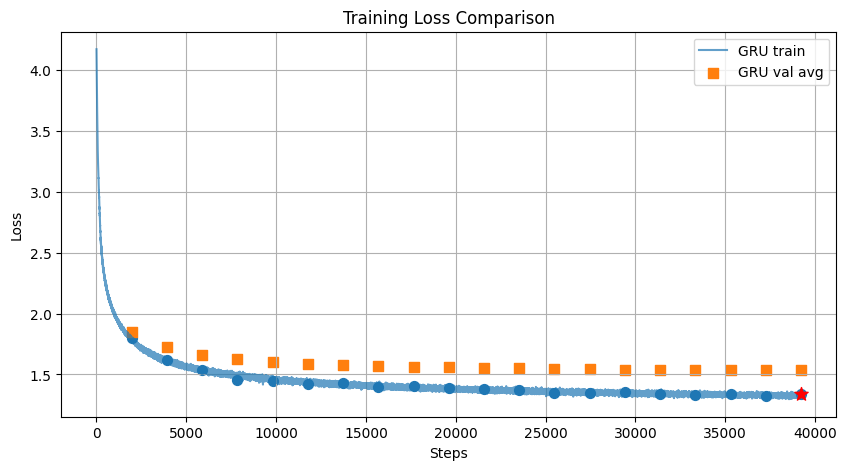

In [26]:
plot_loss_comparisons()

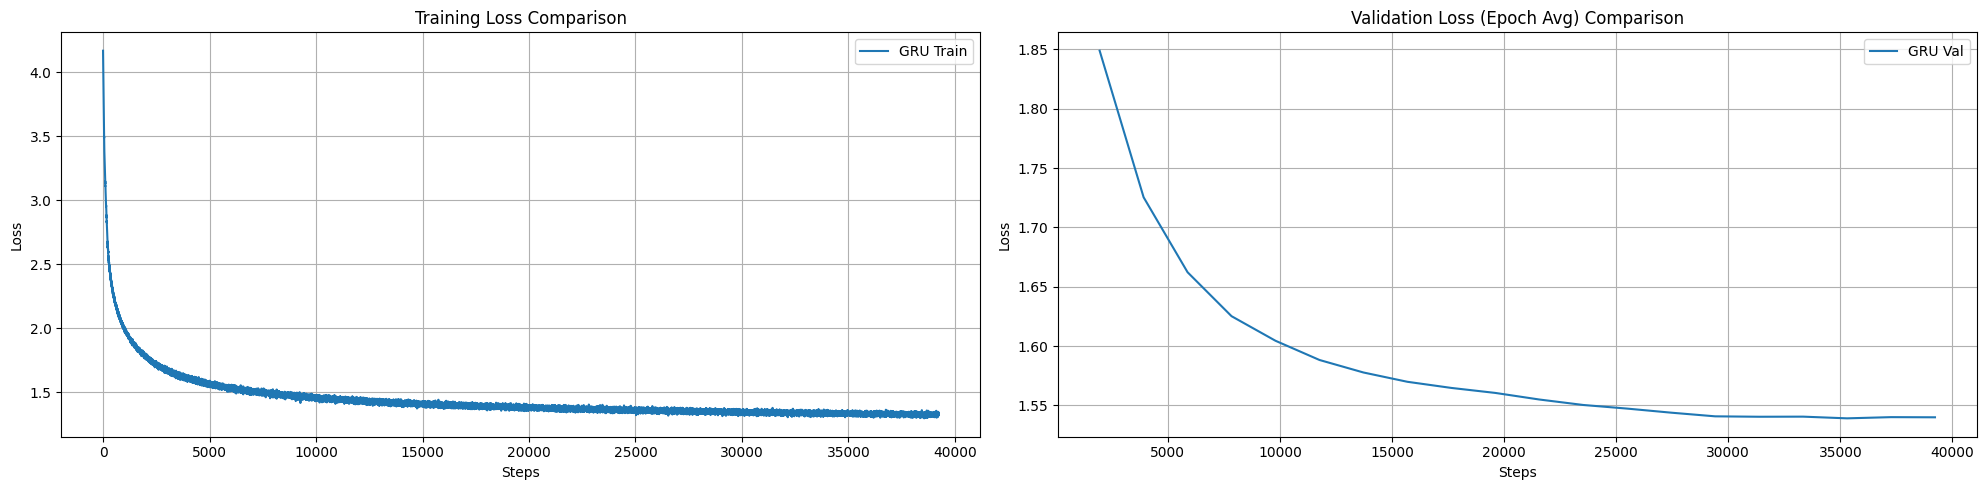

In [27]:
plot_separate_train_val(loss_comparison_dict)

In [28]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)[0]  # No hidden state needed for attention-based models
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [29]:
def train_and_test(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, fused=True)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)
    
    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

## Model 2: Modern Transformer(LLaMA - 2023)

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass

@dataclass
class ModelArgs:
    DIM = EMBEDDING_DIM 
    FFN_DIM = FFN_DIM
    NUM_HEADS = NUM_HEADS 
    NUM_LAYERS = NUM_LAYERS

    NUM_KV_HEADS = NUM_HEADS 
    VOCAB_SIZE = vocab_size
    NORM_EPS = 1e-5 # LLaMA: 1e-5
    ROPE_THETA = 10000 # LLaMA: 10000

    MAX_BATCH_SIZE = BATCH_SIZE
    MAX_SEQ_LEN = SEQUENCE_LENGTH # depending on the DATASET
    NUM_KV_HEAD_REP = NUM_HEADS // NUM_KV_HEADS

    HEAD_DIM = DIM // NUM_HEADS
    DROPOUT = DROPOUT
    DEVICE = device

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x: torch.Tensor):
        return self.weight.to(x.device) * self._norm(x.float()).type_as(x)
    
def precompute_freqs_cis(head_dim: int, seq_len: int, theta: float = 100.0, device: str = "cuda:1"):
    if head_dim % 2 != 0:
        raise ValueError("head_dim must be even for rotary embeddings.")
    freqs = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim)).to(device)
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [seq_len, head_dim//2]
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis  # [seq_len, head_dim // 2]

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    L = x.shape[1]
    return freqs_cis.view(1, L, 1, x.shape[-1] // 2)  # [1, L, 1, head_dim]

def apply_rotary_emb(x: torch.Tensor, device: str = "cuda:1"):
    # x: [B, L, 2*heads, D] & D is even
    _, L, _, D = x.shape
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)) # [B, L, 2*heads, D//2, 2]
    freqs_cis = precompute_freqs_cis(D, L)
    freqs = reshape_for_broadcast(freqs_cis, x)
    x_rotated = x_complex * freqs
    x_out = torch.view_as_real(x_rotated).reshape(x.shape)
    return x_out.type_as(x).to(device)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    B, L, nk, d = x.shape
    if n_rep == 1:
        return x
    return x[:, :, :, None, :].expand(B, L, nk, n_rep, d).reshape(B, L, nk * n_rep, d)

class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        hidden_dim = ffn_dim
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor):
        # x: [B, L, D]
        return self.w2(F.silu(self.w1(x)) * self.dropout(self.w3(x)))

class SelfAttention(nn.Module):
    def __init__(self, n_heads, n_kv_heads, n_rep, dim, dropout, batch, seq_len, device):
        super().__init__()
        self.n_heads_q = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_rep
        self.head_dim = dim // n_heads

        self.wq = nn.Linear(dim, n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(n_heads * self.head_dim, dim, bias=False)
        self.attn_dropout = dropout
        
        self.norm = RMSNorm(self.head_dim)

    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        B, L, _ = x.shape
        src_len = trg_len = L
        offset = start_pos
        
        xq = self.wq(x).view(B, L, self.n_heads_q, self.head_dim)
        xk = self.wk(x).view(B, L, self.n_kv_heads, self.head_dim)
        xv = self.wv(x).view(B, L, self.n_kv_heads, self.head_dim)
        
        # Apply rotary embeddings
        xq = apply_rotary_emb(xq)
        xk = apply_rotary_emb(xk)
        
        # GQA: Adjust dimensions for attention computation
        xq = xq.transpose(1, 2)   # [B, n_heads, L, head_dim]
        xk = repeat_kv(xk, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]
        xv = repeat_kv(xv, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]

        # Compute scaled dot-product attention manually to capture attention weights
        scores = torch.matmul(xq, xk.transpose(-2, -1)) / math.sqrt(self.head_dim)  # [B, n_heads, L, L]
        scores = torch.nan_to_num(scores)
        if mask is None:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(attn_weights),
                1 + offset,
            )
            
        scores += mask
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = F.dropout(attn_weights, self.attn_dropout, training=self.training)
        attn_output = torch.matmul(attn_weights, xv)  # [B, n_heads, L, head_dim]
        attn_output = self.norm(attn_output)
        
        # Reshape attention output and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, L, -1)
        output = self.wo(attn_output)  # [B, L, D]
        if return_attn:
            return output, attn_weights
        else:
            return output

class TransformerBlock(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.attention = SelfAttention(
            args.NUM_HEADS, 
            args.NUM_KV_HEADS, 
            args.NUM_KV_HEAD_REP, 
            args.DIM, 
            args.DROPOUT, 
            args.MAX_BATCH_SIZE, 
            args.MAX_SEQ_LEN, 
            args.DEVICE
        )
        self.ffn = FeedForward(args.DIM, args.FFN_DIM, args.DROPOUT)
        self.attention_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.ffn_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.res_dropout = nn.Dropout(args.DROPOUT)
        
    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        if return_attn:
            attn_out, attn_map = self.attention(self.attention_norm(x), start_pos, mask, return_attn=True)
            h = x + self.res_dropout(attn_out)
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h, attn_map
        else:
            h = x + self.res_dropout(self.attention(self.attention_norm(x), start_pos, mask))
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h

class LlamaTransformer(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.args = args
        self.tok_embeddings = nn.Embedding(args.VOCAB_SIZE, args.DIM)
        self.layers = nn.ModuleList([TransformerBlock(args) for _ in range(args.NUM_LAYERS)])
        self.norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.output = nn.Linear(args.DIM, args.VOCAB_SIZE, bias=False)
        self.device = args.DEVICE
        
    def forward(self, x: torch.Tensor, start_pos=0, return_attn=False):
        B, L = x.shape
        h = self.tok_embeddings(x)  # [B, L, D]
        
        mask = None
        if L > 1:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(x),
                1 + start_pos,
            )
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                h, attn_map = layer(h, start_pos, mask, return_attn=True)
                attn_maps.append(attn_map)
            else:
                h = layer(h, start_pos, mask)
        logits = self.output(self.norm(h)).float()
        if return_attn:
            return logits, attn_maps
        return logits, _

In [38]:
PARAMS = ModelArgs()
llama = LlamaTransformer(PARAMS).to(device)
llama

LlamaTransformer(
  (tok_embeddings): Embedding(65, 64)
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attention): SelfAttention(
        (wq): Linear(in_features=64, out_features=64, bias=False)
        (wk): Linear(in_features=64, out_features=64, bias=False)
        (wv): Linear(in_features=64, out_features=64, bias=False)
        (wo): Linear(in_features=64, out_features=64, bias=False)
        (norm): RMSNorm()
      )
      (ffn): FeedForward(
        (w1): Linear(in_features=64, out_features=256, bias=False)
        (w2): Linear(in_features=256, out_features=64, bias=False)
        (w3): Linear(in_features=64, out_features=256, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (res_dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=64, out_features=65, bias=False)
)

In [39]:
summary(llama.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
LlamaTransformer                         [512, 64, 65]             --
├─Embedding: 1-1                         [512, 64, 64]             4,160
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [512, 64, 64]             --
│    │    └─RMSNorm: 3-1                 [512, 64, 64]             64
│    │    └─SelfAttention: 3-2           [512, 64, 64]             16,400
│    │    └─Dropout: 3-3                 [512, 64, 64]             --
│    │    └─RMSNorm: 3-4                 [512, 64, 64]             64
│    │    └─FeedForward: 3-5             [512, 64, 64]             49,152
│    │    └─Dropout: 3-6                 [512, 64, 64]             --
│    └─TransformerBlock: 2-2             [512, 64, 64]             --
│    │    └─RMSNorm: 3-7                 [512, 64, 64]             64
│    │    └─SelfAttention: 3-8           [512, 64, 64]             16,400


Epoch 1/20, Train Loss: 1.8819, Val Loss: 1.8444, Epoch Time: 58.74s Average Vram Usage: 91.36MB


Epoch 2/20, Train Loss: 1.6866, Val Loss: 1.7588, Epoch Time: 60.40s Average Vram Usage: 91.36MB


Epoch 3/20, Train Loss: 1.6228, Val Loss: 1.7533, Epoch Time: 60.38s Average Vram Usage: 91.36MB


Epoch 4/20, Train Loss: 1.5446, Val Loss: 1.7467, Epoch Time: 57.89s Average Vram Usage: 91.36MB


Epoch 5/20, Train Loss: 1.5309, Val Loss: 1.7235, Epoch Time: 58.30s Average Vram Usage: 91.36MB


Epoch 6/20, Train Loss: 1.5419, Val Loss: 1.7134, Epoch Time: 59.70s Average Vram Usage: 91.36MB


Epoch 7/20, Train Loss: 1.4919, Val Loss: 1.7036, Epoch Time: 58.76s Average Vram Usage: 91.36MB


Epoch 8/20, Train Loss: 1.5011, Val Loss: 1.6899, Epoch Time: 59.84s Average Vram Usage: 91.36MB


Epoch 9/20, Train Loss: 1.4860, Val Loss: 1.6848, Epoch Time: 57.02s Average Vram Usage: 91.36MB


Epoch 10/20, Train Loss: 1.4752, Val Loss: 1.6742, Epoch Time: 60.20s Average Vram Usage: 91.36MB


Epoch 11/20, Train Loss: 1.4737, Val Loss: 1.6788, Epoch Time: 60.52s Average Vram Usage: 91.36MB


Epoch 12/20, Train Loss: 1.4477, Val Loss: 1.6684, Epoch Time: 60.67s Average Vram Usage: 91.36MB


Epoch 13/20, Train Loss: 1.4554, Val Loss: 1.6667, Epoch Time: 59.96s Average Vram Usage: 86.18MB


Epoch 14/20, Train Loss: 1.4550, Val Loss: 1.6624, Epoch Time: 60.18s Average Vram Usage: 51.08MB


Epoch 15/20, Train Loss: 1.4489, Val Loss: 1.6549, Epoch Time: 60.14s Average Vram Usage: 51.08MB


Epoch 16/20, Train Loss: 1.4479, Val Loss: 1.6526, Epoch Time: 60.85s Average Vram Usage: 51.08MB


Epoch 17/20, Train Loss: 1.4291, Val Loss: 1.6500, Epoch Time: 59.80s Average Vram Usage: 51.08MB


Epoch 18/20, Train Loss: 1.4138, Val Loss: 1.6595, Epoch Time: 60.31s Average Vram Usage: 51.08MB


Epoch 19/20, Train Loss: 1.3992, Val Loss: 1.6515, Epoch Time: 59.35s Average Vram Usage: 51.08MB


Epoch 20/20, Train Loss: 1.4195, Val Loss: 1.6520, Epoch Time: 58.59s Average Vram Usage: 51.08MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow to go fee!

ISABELLA:
Being curse sworn your sight thou there's made
'As this deserved your lord!

ROMEO:
My Lord, not to him a vilgain. Then thou all leating to his bitter's I
have.

LUCIO:
What your voices had one a sir, by this child,
Hollock'd with arms, and show in my father to thee.

BISHAM:
Have she that you, the duke this name,
And Pompey, what thou deliver in thee;
And till here, how was dry, who do your rebelline,
To thou art thou comest three with powers.

CAMILLO:
Here's not deligh


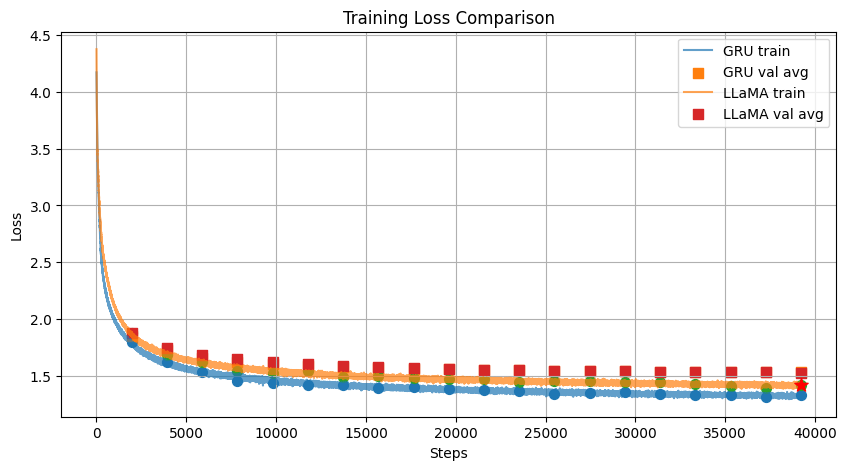

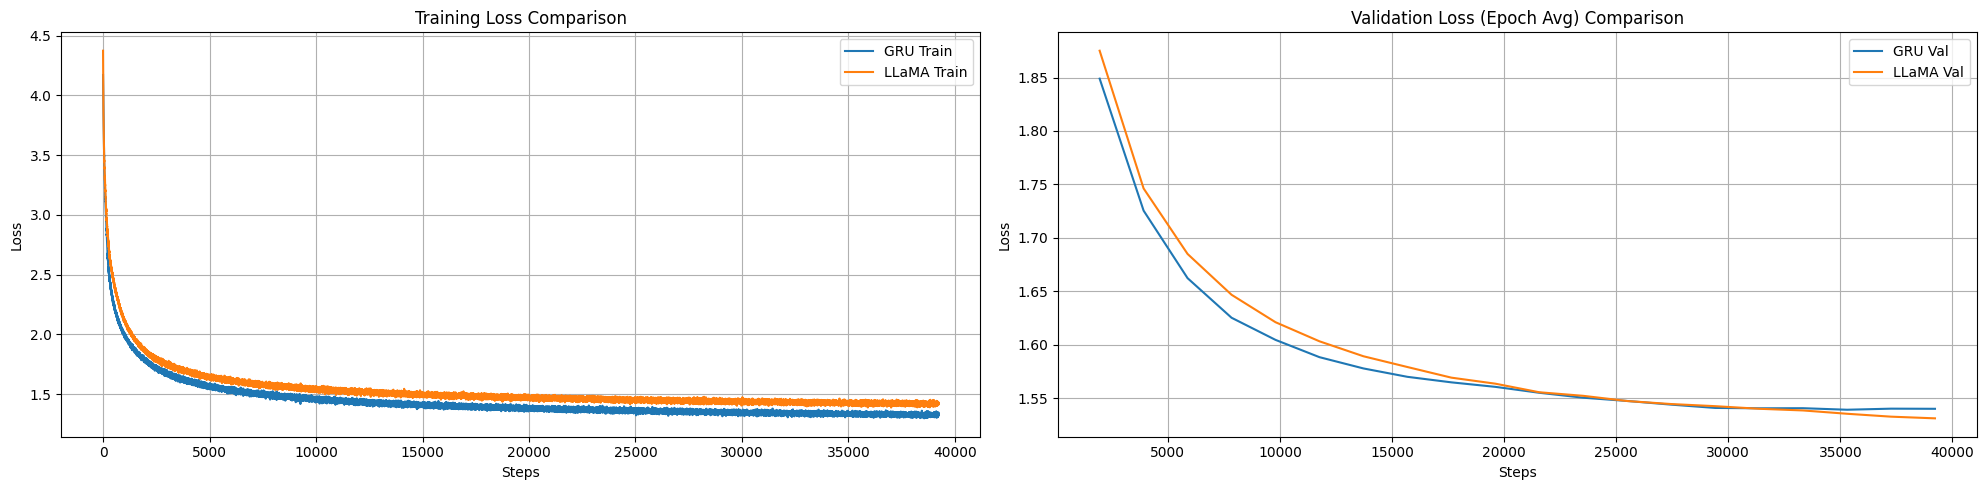

In [40]:
train_and_test("LLaMA", llama, start_text)

## Model 3: Mamba

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import math # For initialization if needed

# --- Assume mamba_ssm is installed ---
# pip install mamba-ssm causal-conv1d
try:
    from causal_conv1d import causal_conv1d_fn, causal_conv1d_update # Need both for training/inference
    # causal_conv1d_fn is the main function for training/full sequence processing
except ImportError:
    print("Warning: 'causal_conv1d' package not found. Falling back to nn.Conv1d simulation.")
    print("Install with: pip install causal-conv1d")
    causal_conv1d_fn = None # Placeholder

try:
    from mamba_ssm.ops.selective_scan_interface import selective_scan_fn, mamba_inner_fn
    # selective_scan_fn wraps the CUDA/Triton kernel
except ImportError:
    print("Warning: 'mamba_ssm' package not found or compiled kernels unavailable.")
    print("SSM scan will use the less efficient PyTorch implementation.")
    print("Install with: pip install mamba-ssm")
    selective_scan_fn = None # Placeholder

[2025-05-21 08:43:01,054] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2025-05-21 08:43:02.797963: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-21 08:43:03.631607: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
import math
from causal_conv1d import causal_conv1d_fn
from mamba_ssm.ops.selective_scan_interface import selective_scan_fn

# --- RMSNorm (Root Mean Square Layer Normalization) ---
class RMSNorm(nn.Module):
    """RMS 정규화 레이어.

    Args:
        dim (int): 정규화할 벡터의 차원.
        eps (float, optional): 분모에 더할 작은 값 (0으로 나누는 것 방지). 기본값: 1e-6.
    """
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        # 학습 가능한 스케일링 파라미터 (gamma)
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x: torch.Tensor) -> torch.Tensor:
        """RMS 정규화 계산 수행."""
        # 계산 안정성을 위해 float32 사용 후 원본 타입 복원
        original_dtype = x.dtype
        # 입력의 제곱 평균의 제곱근 역수 계산
        rms = torch.rsqrt(x.to(torch.float32).pow(2).mean(-1, keepdim=True) + self.eps)
        return (x * rms).to(original_dtype)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """RMS 정규화 적용."""
        # 정규화 후 학습 가능한 가중치 적용
        return self.weight * self._norm(x)

# --- SSM (State Space Model) 모듈 ---
class SSM(nn.Module):
    """선택적 스캔 메커니즘 (SSM). 최적화된 selective_scan_fn 커널 사용.
       Mamba v1 논문의 파라미터화 및 계산 방식 (non-fused path) 기반.
       selective_scan_fn이 기대하는 특정 텐서 레이아웃(B,D,L / B,N,L 등)을 따름.

    Args:
        d_inner (int): 내부 확장 차원 (D).
        state_size (int): SSM 상태 벡터 크기 (N).
        dt_rank (str or int, optional): Δ 계산 시 사용될 중간 랭크. "auto"시 d_inner / 16. 기본값: "auto".
        dt_min (float, optional): Δ의 최소값 제한 (softplus 적용 후). 기본값: 0.001.
        dt_max (float, optional): Δ의 최대값 제한 (softplus 적용 후). 기본값: 0.1.
        dt_init (str, optional): dt_proj 가중치 초기화 방식 ("random" or "constant"). 기본값: "random".
        dt_scale (float, optional): dt_proj 가중치 초기화 스케일. 기본값: 1.0.
        dt_init_floor (float, optional): dt 초기값 하한선. 기본값: 1e-4.
        bias (bool, optional): x_proj 레이어에 bias 사용 여부. 기본값: False.
        device (str, optional): 연산 장치. 기본값: 'cuda'.
        dtype (torch.dtype, optional): 연산 데이터 타입. 기본값: torch.float32.
    """
    def __init__(self, d_inner: int, state_size: int, dt_rank: str | int ="auto", dt_min: float =0.001, dt_max: float =0.1,
                 dt_init: str ="random", dt_scale: float =1.0, dt_init_floor: float =1e-4, bias: bool =False,
                 device: str ='cuda', dtype: torch.dtype =torch.float32):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.d_inner = d_inner
        self.state_size = state_size
        # dt_rank 자동 계산 또는 지정값 사용
        self.dt_rank = math.ceil(d_inner / 16) if dt_rank == "auto" else dt_rank
        self.device = device
        self.dtype = dtype

        # 컨볼루션 출력(x)을 받아 dt_inter, B, C 계산용 프로젝션 (Mamba v1 non-fused 방식)
        self.x_proj = nn.Linear(self.d_inner, self.dt_rank + self.state_size * 2, bias=bias, **factory_kwargs)

        # dt_inter를 받아 dt 계산용 프로젝션
        self.dt_proj = nn.Linear(self.dt_rank, self.d_inner, bias=True, **factory_kwargs)

        # --- dt_proj bias 특별 초기화 (Mamba v1 공식 코드 참조) ---
        # 초기화 시 softplus(bias) 결과가 [dt_min, dt_max] 범위에 있도록 조정
        dt_init_std = self.dt_rank**-0.5 * dt_scale
        if dt_init == "constant":
            nn.init.constant_(self.dt_proj.weight, dt_init_std)
        elif dt_init == "random":
            nn.init.uniform_(self.dt_proj.weight, -dt_init_std, dt_init_std)
        else:
            raise NotImplementedError(f"Invalid dt_init: {dt_init}")

        # dt bias 초기값 계산 (softplus의 역함수 활용)
        dt = torch.exp(
            torch.rand(self.d_inner, **factory_kwargs) * (math.log(dt_max) - math.log(dt_min))
            + math.log(dt_min)
        ).clamp(min=dt_init_floor)
        inv_dt = dt + torch.log(-torch.expm1(-dt)) # softplus(inv_dt) ≈ dt
        with torch.no_grad():
            self.dt_proj.bias.copy_(inv_dt)
        # 다른 초기화 루틴에서 이 bias를 덮어쓰지 않도록 플래그 설정 (선택적)
        self.dt_proj.bias._no_reinit = True
        # --- dt_proj bias 초기화 종료 ---

        # --- SSM 파라미터 A (A_log) ---
        # S4D-Real 방식 초기화: A 행렬의 대각 요소가 [1, 2, ..., N]이 되도록 A_log 설정
        A = repeat(
            torch.arange(1, self.state_size + 1, dtype=torch.float32, device=device),
            "n -> d n", # 1차원 벡터를 d_inner 번 반복하여 (D, N) 행렬 생성
            d=self.d_inner,
        ).contiguous()
        A_log = torch.log(A) # 로그 스케일에서 파라미터 학습 (float32 유지)
        self.A_log = nn.Parameter(A_log)
        self.A_log._no_weight_decay = True # 가중치 감쇠 제외

        # --- SSM 파라미터 D (피드스루) ---
        # 형태: (D)
        self.D = nn.Parameter(torch.ones(self.d_inner, device=device)) # float32 유지 권장
        self.D._no_weight_decay = True # 가중치 감쇠 제외

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """SSM 순방향 계산. 입력 x는 (B, D, L) 레이아웃을 가정."""
        B, D, L = x.shape # 입력 레이아웃 확인
        if D != self.d_inner:
            raise ValueError(f"입력 차원 D({D})가 SSM 내부 차원({self.d_inner})과 불일치")

        # 1. 입력 x(컨볼루션 출력)로부터 dt, B, C 계산
        #    선형 프로젝션을 위해 (B*L, D) 형태로 변환
        x_reshaped = rearrange(x, "b d l -> (b l) d")
        x_proj_out = self.x_proj(x_reshaped) # 결과: (B*L, dt_rank + 2*N)
        dt_inter, B, C = torch.split(x_proj_out, [self.dt_rank, self.state_size, self.state_size], dim=-1)

        # 2. dt 계산 (softplus 적용 전) -> 형태 (B, D, L)
        #    dt_inter: (B*L, dt_rank)
        #    Mamba v1 non-fused path 방식 적용
        dt = self.dt_proj.weight @ dt_inter.t() # 결과: (D, B*L)
        dt = rearrange(dt, "d (b l) -> b d l", l=L) # 최종 형태: (B, D, L)
        # dt_bias는 selective_scan_fn 내부에서 delta_bias 인자로 전달되어 더해짐

        # 3. A 행렬 계산, 형태 (D, N)
        A = -torch.exp(self.A_log.float()) # float32에서 exp 계산

        # 4. B, C 형태 변경 -> (B, N, L)
        #    selective_scan_fn 커널이 요구하는 레이아웃
        B = rearrange(B, "(b l) n -> b n l", l=L).contiguous()
        C = rearrange(C, "(b l) n -> b n l", l=L).contiguous()

        # 5. D 파라미터 준비, 형태 (D)
        D_param = self.D.float().contiguous()

        # 6. selective_scan_fn 입력 준비 (메모리 연속성 보장)
        input_u = x.contiguous()             # u (SSM 입력): (B, D, L)
        input_delta = dt.contiguous()        # delta (dt): (B, D, L)
        input_A = A.contiguous()             # A: (D, N)
        input_B = B                          # B: (B, N, L)
        input_C = C                          # C: (B, N, L)
        input_D = D_param                    # D: (D)
        input_delta_bias = self.dt_proj.bias.float().contiguous() if self.dt_proj.bias is not None else None

        # 7. 최적화된 selective_scan_fn 호출
        #    입력 레이아웃 및 파라미터 형태는 Mamba v1 non-fused path 기준
        y = selective_scan_fn(
            u=input_u,
            delta=input_delta,
            A=input_A,
            B=input_B,
            C=input_C,
            D=input_D,
            z=None, # 게이트 z는 MambaBlock 레벨에서 처리
            delta_bias=input_delta_bias, # dt_bias 전달
            delta_softplus=True, # 내부에서 delta = softplus(dt + delta_bias) 계산
        )

        # 8. 결과 반환, 형태 (B, D, L)
        #    후속 처리를 위해 이 레이아웃 유지
        return y


# --- Mamba 블록 (causal_conv1d_fn 사용 및 데이터 흐름 수정) ---
class MambaBlock(nn.Module):
    """Mamba 핵심 블록. RMSNorm, 입력 프로젝션, 인과적 컨볼루션, SSM, 게이팅, 출력 프로젝션 구성.
       내부적으로 (B, D, L) 텐서 레이아웃 사용.
    """
    def __init__(self, d_model: int, state_size: int, d_conv: int = 4, expand: int = 2,
                 dropout_prob: float = 0.1, device: str = 'cuda', dtype: torch.dtype = torch.float32):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.d_model = d_model
        self.d_inner = int(expand * d_model) # 내부 확장 차원 (D)
        self.state_size = state_size
        self.d_conv = d_conv
        self.device = device
        self.dtype = dtype

        # 입력 정규화 (RMSNorm)
        self.norm = RMSNorm(d_model, eps=1e-5)

        # 입력 프로젝션 (d_model -> 2 * d_inner)
        self.in_proj = nn.Linear(d_model, 2 * self.d_inner, bias=False, **factory_kwargs)

        # 인과적 컨볼루션 파라미터 (가중치 형태: D, K)
        self.conv1d_weight = nn.Parameter(torch.empty(self.d_inner, d_conv, **factory_kwargs))
        self.conv1d_bias = nn.Parameter(torch.empty(self.d_inner, **factory_kwargs))

        # SSM 모듈 인스턴스화 (Mamba v1 파라미터 전달 옵션 추가 가능)
        self.ssm = SSM(self.d_inner, state_size, device=device, dtype=dtype)
                      # dt_rank, dt_min 등 SSM 파라미터 전달 가능

        # 출력 프로젝션 (d_inner -> d_model)
        self.out_proj = nn.Linear(self.d_inner, d_model, bias=False, **factory_kwargs)

        # 잔차 연결 드롭아웃
        self.dropout_res = nn.Dropout(dropout_prob)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Mamba 블록 순방향 계산."""
        B, L, D_model = x.shape # 입력 형태: (B, L, d_model)
        residual = x # 잔차 연결용 원본 저장

        # 1. 입력 정규화
        x_norm = self.norm(x)

        # 2. 입력 프로젝션 및 분할 (x_in, z)
        xz = self.in_proj(x_norm) # 결과: (B, L, 2*D)
        x_in, z = xz.chunk(2, dim=-1) # 각각: (B, L, D)

        # 3. 인과적 컨볼루션 브랜치
        #    입력 레이아웃 변경: (B, L, D) -> (B, D, L)
        x_conv_in = rearrange(x_in, 'b l d -> b d l').contiguous()
        #    최적화된 causal_conv1d_fn 호출 (SiLU 활성화 포함)
        #    출력 x_conv_out 형태: (B, D, L)
        x_conv_out = causal_conv1d_fn(
            x=x_conv_in, weight=self.conv1d_weight, bias=self.conv1d_bias, activation='silu'
        )

        # 4. SSM 브랜치
        #    컨볼루션 출력(B, D, L)을 SSM에 직접 전달
        #    SSM 출력 y_ssm 형태: (B, D, L)
        y_ssm = self.ssm(x_conv_out)

        # 5. 게이팅 메커니즘
        #    y_ssm을 z와 곱하기 위해 (B, L, D) 형태로 변경
        y_ssm_rearranged = rearrange(y_ssm, 'b d l -> b l d')
        #    z에 SiLU 활성화 적용 후 요소별 곱셈
        y_gated = y_ssm_rearranged * F.silu(z) # 결과: (B, L, D)

        # 6. 출력 프로젝션
        output = self.out_proj(y_gated) # 결과: (B, L, d_model)

        # 7. 잔차 연결 및 드롭아웃
        output = residual + self.dropout_res(output) # 최종 결과: (B, L, d_model)

        return output

# --- Mamba 모델 전체 ---
class Mamba(nn.Module):
    """Mamba 언어 모델 전체 구조."""
    def __init__(self, d_model: int, n_layers: int, vocab_size: int, state_size: int = 16,
                 d_conv: int = 4, expand: int = 2, dropout_prob: float = 0.1,
                 device: str = 'cuda', dtype: torch.dtype = torch.float32):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.vocab_size = vocab_size
        # 저장된 파라미터는 validation 등에 사용될 수 있음
        self.state_size = state_size
        self.d_conv = d_conv
        self.expand = expand
        self.dropout_prob = dropout_prob
        self.device = device
        self.dtype = dtype

        # 토큰 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model, **factory_kwargs)
        self.dropout_emb = nn.Dropout(dropout_prob)

        # Mamba 블록 스택
        self.layers = nn.ModuleList([
            MambaBlock(
                d_model=d_model, state_size=state_size, d_conv=d_conv,
                expand=expand, dropout_prob=dropout_prob, device=device, dtype=dtype
            ) for _ in range(n_layers)
        ])

        # 최종 정규화 레이어
        self.norm_f = RMSNorm(d_model, eps=1e-5)
        # 언어 모델링 헤드 (출력 레이어)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False, **factory_kwargs)

        # 가중치 공유 (임베딩과 LM 헤드)
        self.lm_head.weight = self.embedding.weight

        # 모델 가중치 초기화 적용
        self.apply(self._init_weights)
        print(f"Mamba 모델 초기화 완료. Device: {device}, Dtype: {dtype}")

    def _init_weights(self, module):
        """모델의 각 모듈 가중치 초기화."""
        if isinstance(module, nn.Linear):
            # dt_proj의 bias는 특별 초기화되므로 건너뜀
            if hasattr(module.bias, '_no_reinit') and module.bias._no_reinit:
                return
            # Linear 레이어 가중치 초기화 (예: GPT-2 스타일)
            std = 0.02
            # 모델 깊이에 따른 스케일링 (옵션)
            if self.n_layers > 0:
                 # 입력/출력 프로젝션 등 특정 레이어에만 적용 고려 가능
                 if module.weight.shape[0] == self.d_model or module.weight.shape[1] == self.d_model:
                     std /= math.sqrt(2.0 * self.n_layers)
            nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            # 임베딩 가중치 초기화
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, MambaBlock):
            # MambaBlock 내의 Conv1d 가중치 초기화
            if hasattr(module, 'conv1d_weight'):
                # Kaiming 초기화 (SiLU 활성화 함수에 적합)
                nn.init.kaiming_normal_(module.conv1d_weight, nonlinearity='leaky_relu')
            if hasattr(module, 'conv1d_bias'):
                nn.init.zeros_(module.conv1d_bias)
        # RMSNorm 가중치는 해당 클래스 생성자에서 1로 초기화됨
        # SSM 파라미터 (A_log, D)는 해당 클래스 생성자에서 초기화됨

    def forward(self, input_ids: torch.Tensor) -> tuple[torch.Tensor, None]:
        """Mamba 모델 순방향 계산."""
        B, L = input_ids.shape

        # 1. 임베딩 및 드롭아웃
        # 임베딩 레이어는 LongTensor 입력 필요
        x = self.embedding(input_ids.long())
        x = self.dropout_emb(x)

        # 2. Mamba 블록 순차 적용
        for layer in self.layers:
            x = layer(x)

        # 3. 최종 정규화
        x = self.norm_f(x)

        # 4. LM 헤드를 통해 로짓 계산
        logits = self.lm_head(x) # 결과: [B, L, vocab_size]

        # Loss 계산은 외부 학습 루프에서 처리 (labels 사용)
        # 여기서는 로짓과 None 반환 (일반적인 Hugging Face 모델 스타일)
        return logits, None

In [43]:
'''
- pip install causal-conv1d
- mamba github clone > setup.py build > setup.py install
- sudo apt-get update && sudo apt-get install -y libaio-dev
'''

'\n- pip install causal-conv1d\n- mamba github clone > setup.py build > setup.py install\n- sudo apt-get update && sudo apt-get install -y libaio-dev\n'

In [44]:
STATE_SIZE = 8

x = torch.randint(0, vocab_size, (BATCH_SIZE, SEQUENCE_LENGTH)).to(device)

mamba = Mamba(HIDDEN_DIM, NUM_LAYERS, vocab_size, STATE_SIZE, d_conv=4, expand=3).to(device)

test_output, _ = mamba(x)
print(f"test_output.shape = {test_output.shape}") 

Mamba 모델 초기화 완료. Device: cuda, Dtype: torch.float32
test_output.shape = torch.Size([512, 64, 65])


In [45]:
from torchinfo import summary

summary(mamba.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
Mamba                                    [512, 64, 65]             --
├─Embedding: 1-1                         [512, 64, 128]            8,320
├─Dropout: 1-2                           [512, 64, 128]            --
├─ModuleList: 1-3                        --                        --
│    └─MambaBlock: 2-1                   [512, 64, 128]            1,920
│    │    └─RMSNorm: 3-1                 [512, 64, 128]            128
│    │    └─Linear: 3-2                  [512, 64, 768]            98,304
│    │    └─SSM: 3-3                     [512, 384, 64]            28,416
│    │    └─Linear: 3-4                  [512, 64, 128]            49,152
│    │    └─Dropout: 3-5                 [512, 64, 128]            --
│    └─MambaBlock: 2-2                   [512, 64, 128]            1,920
│    │    └─RMSNorm: 3-6                 [512, 64, 128]            128
│    │    └─Linear: 3-7                  [512, 64, 768]       

In [ ]:
train_and_test("Mamba", mamba, start_text)

Epoch 1:   0%|          | 0/1961 [00:00<?, ?it/s]

## mingru

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math # math.log 및 상수 사용을 위함
from tqdm import tqdm # tqdm 임포트 추가

# Lion 옵티마이저 임포트 (설치 필요: pip install lion-pytorch)
# from lion_pytorch import Lion # 주석 처리 - 실제 사용 시 주석 해제

def log_g(x: torch.Tensor) -> torch.Tensor:
    """
    은닉 상태 후보를 로그 공간으로 변환하는 함수.
    x >= 0 이면 log(x + 0.5)
    x < 0 이면 log(sigmoid(x))
    """
    return torch.where(x >= 0, (F.relu(x) + 0.5).log(), -F.softplus(-x))

def parallel_scan_log(log_coeffs: torch.Tensor, log_values: torch.Tensor) -> torch.Tensor:
    """
    로그 공간에서 병렬 스캔 연산을 수행합니다. (클램핑 제거됨)
    Args:
        log_coeffs (torch.Tensor): [B, L, H_internal] 형태의 텐서로, log(alpha_t)를 나타냅니다.
        log_values (torch.Tensor): [B, L+1, H_internal] 형태의 텐서로, [log_h_initial, log(beta_1), ..., log(beta_L)]를 나타냅니다.
    Returns:
        torch.Tensor: [B, L, H_internal] 형태의 텐서로, 지수 함수가 적용된 은닉 상태 (h_1 부터 h_L까지)를 나타냅니다.
    """
    log_proda_coeffs_prefix = F.pad(torch.cumsum(log_coeffs, dim=1), (0, 0, 1, 0), value=0.0)
    terms_for_logcumsumexp = log_values - log_proda_coeffs_prefix
    log_sum_exp_terms = torch.logcumsumexp(terms_for_logcumsumexp, dim=1) 
    log_hidden_states = log_proda_coeffs_prefix + log_sum_exp_terms
    output_hidden_states = torch.exp(log_hidden_states[:, 1:, :]) 
    return output_hidden_states

class ParallelLogMinGRU(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, expansion_factor: float = 1.0, epsilon: float = 1e-7):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.expansion_factor = expansion_factor
        self.internal_expanded_dim = int(hidden_size * expansion_factor)
        self.epsilon = epsilon
        self.to_hidden_and_gate = nn.Linear(input_size, self.internal_expanded_dim * 2)
        if self.expansion_factor != 1.0:
            self.to_out = nn.Linear(self.internal_expanded_dim, hidden_size)
        else:
            self.to_out = nn.Identity()
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'linear' in name or 'to_hidden_and_gate' in name or 'to_out' in name :
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name: 
                    nn.init.zeros_(param)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L, _ = x.size()
        hidden_and_gate = self.to_hidden_and_gate(x)
        h_candidate_input_expanded, logits_z_expanded = hidden_and_gate.chunk(2, dim=-1)
        log_A = F.logsigmoid(-logits_z_expanded)
        log_Z_expanded = F.logsigmoid(logits_z_expanded)
        log_h_candidate_contrib_expanded = log_g(h_candidate_input_expanded)
        log_B = log_Z_expanded + log_h_candidate_contrib_expanded
        log_h0_val = torch.full((B, 1, self.internal_expanded_dim),
                                math.log(self.epsilon),
                                device=x.device, dtype=x.dtype)
        log_vals = torch.cat([log_h0_val, log_B], dim=1)
        h_expanded_scan_out = parallel_scan_log(log_A, log_vals)
        if self.expansion_factor != 1.0:
            output = self.to_out(h_expanded_scan_out)
        else:
            output = h_expanded_scan_out
        return output

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-8):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        variance = x.pow(2).mean(dim=-1, keepdim=True)
        return x * torch.rsqrt(variance + self.eps) * self.gamma

class CausalDepthWiseConv1d(nn.Module):
    def __init__(self, dim: int, kernel_size: int):
        super().__init__()
        self.kernel_size = kernel_size
        self.net = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, groups=dim), 
            nn.Conv1d(dim, dim, kernel_size=1)                       
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_orig_shape = x.shape
        if x.ndim == 2: 
            x = x.unsqueeze(0) 
        x_transposed = x.transpose(1, 2) 
        x_padded = F.pad(x_transposed, (self.kernel_size - 1, 0), value=0.)
        x_conv_out = self.net(x_padded)
        x_restored = x_conv_out.transpose(1, 2) 
        if x_orig_shape.ndim == 2 and x_restored.shape[0] == 1:
            x_restored = x_restored.squeeze(0) 
        return x_restored

class SwiGLUFFN(nn.Module):
    def __init__(self, dim: int, expansion_factor: float = 4.0, dropout: float = 0.0):
        super().__init__()
        hidden_dim = int(dim * expansion_factor * (2/3)) # SwiGLU는 종종 2/3 hidden_dim을 사용 (두 브랜치 때문)
                                                        # 또는, (dim * expansion_factor)를 각 브랜치의 hidden_dim으로 사용
        # 여기서는 LLaMA 스타일로, (dim * expansion_factor)를 중간 차원으로 하고, 이를 쪼개지 않음
        # 대신, 두 개의 Linear 프로젝션을 사용
        # W_hidden: dim -> hidden_dim
        # W_gate: dim -> hidden_dim
        # W_out: hidden_dim -> dim
        # hidden_dim = int(dim * expansion_factor) # 이 방식이 더 일반적일 수 있음
        # 여기서는 Llama2 논문의 SwiGLU 구현을 참고 (hidden_dim은 하나로 통일)
        # (Section 2.2 FFN): FFN_dim = (2/3) * 4 * d_model, and use SwiGLU
        # 즉, 4 * d_model을 한 후, 이를 2/3로 줄인 차원을 사용하거나,
        # 4 * d_model을 두 브랜치로 나누어 사용.
        # 여기서는 간단하게 expansion_factor로 중간 차원을 결정하고,
        # 이 차원을 두 개의 프로젝션(메인, 게이트)에 사용하지 않고,
        # 하나의 프로젝션 후 chunk하는 방식 대신, 두 개의 독립적인 프로젝션을 사용하지도 않고,
        # Llama의 FFN_dim_multiplier 방식을 따름:
        # up_proj, gate_proj: d_model -> multiple_of * d_model
        # down_proj: multiple_of * d_model -> d_model
        # multiple_of는 보통 256의 배수. 여기서는 expansion_factor를 multiple_of로 간주.
        # 단, SwiGLU는 보통 up_proj와 gate_proj의 출력 차원이 같음.
        
        # 일반적인 SwiGLU 구현:
        # 1. x -> x_proj (dim -> hidden_dim * 2)
        # 2. x1, x_gate = x_proj.chunk(2, dim=-1) (각각 hidden_dim)
        # 3. gated = silu(x1) * x_gate
        # 4. output = Linear(hidden_dim, dim)(gated)
        # 여기서 hidden_dim = dim * expansion_factor
        
        ffn_hidden_dim = int(dim * expansion_factor)

        self.w1_w3 = nn.Linear(dim, ffn_hidden_dim * 2, bias=False) # W1과 W3를 한 번에 프로젝션
        self.w2 = nn.Linear(ffn_hidden_dim, dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_proj = self.w1_w3(x)
        x1, x3 = x_proj.chunk(2, dim=-1) # x1은 SiLU 입력, x3는 게이트
        hidden_states = F.silu(x1) * x3
        hidden_states = self.dropout(hidden_states)
        return self.w2(hidden_states)


class MoELayer(nn.Module):
    def __init__(self, dim: int, num_experts: int, ffn_expansion_factor: float, dropout: float, top_k: int = -1):
        super().__init__()
        self.num_experts = num_experts
        self.top_k = top_k if top_k > 0 and top_k <= num_experts else num_experts # top_k가 유효하지 않으면 모든 전문가 사용 (soft MoE)

        self.experts = nn.ModuleList(
            [SwiGLUFFN(dim, expansion_factor=ffn_expansion_factor, dropout=dropout) for _ in range(num_experts)]
        )
        self.gate = nn.Linear(dim, num_experts, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, L, D]
        batch_size, seq_len, dim = x.shape
        x_reshaped = x.view(-1, dim) # [B*L, D]

        gate_logits = self.gate(x_reshaped) # [B*L, num_experts]

        if self.top_k < self.num_experts and self.top_k > 0 : # Sparse MoE (Top-K)
            # 상위 K개 전문가의 가중치와 인덱스 선택
            top_k_weights, top_k_indices = torch.topk(gate_logits, self.top_k, dim=-1) # [B*L, top_k]
            # 선택된 전문가 가중치에 소프트맥스 적용
            top_k_weights = F.softmax(top_k_weights, dim=-1) # [B*L, top_k]

            final_output = torch.zeros_like(x_reshaped) # [B*L, D]
            
            # 각 토큰에 대해 상위 K개 전문가의 출력을 계산하고 가중합
            # 이 방식은 모든 토큰에 대해 루프를 돌거나 복잡한 인덱싱/분산 처리가 필요.
            # 간단한 구현을 위해, 각 전문가를 순회하며 해당 전문가가 선택된 토큰만 처리
            
            # 임시적인 (덜 효율적인) Top-K 구현:
            # 모든 전문가의 출력을 일단 계산하고, 선택된 것만 가중합
            expert_outputs_all = torch.stack([expert(x_reshaped) for expert in self.experts], dim=1) # [B*L, num_experts, D]
            
            # top_k_indices를 사용하여 필요한 전문가 출력 선택 및 가중합
            # final_output = torch.zeros_like(x_reshaped)
            for i in range(x_reshaped.size(0)): # 각 토큰에 대해
                for k_idx in range(self.top_k):
                    expert_idx = top_k_indices[i, k_idx]
                    weight = top_k_weights[i, k_idx]
                    final_output[i] += weight * expert_outputs_all[i, expert_idx]
        
        else: # Soft MoE (모든 전문가 사용)
            weights = F.softmax(gate_logits, dim=-1) # [B*L, num_experts]
            
            # 모든 전문가의 출력을 계산하고 가중합
            # (B*L, num_experts, D) 형태로 전문가 출력을 쌓음
            expert_outputs_stacked = torch.stack([expert(x_reshaped) for expert in self.experts], dim=1)
            
            # 가중치와 전문가 출력을 곱하고 합산
            # weights: [B*L, num_experts] -> [B*L, num_experts, 1]
            # expert_outputs_stacked: [B*L, num_experts, D]
            # weighted_outputs: [B*L, num_experts, D]
            # final_output: [B*L, D]
            final_output = torch.sum(weights.unsqueeze(-1) * expert_outputs_stacked, dim=1)

        return final_output.view(batch_size, seq_len, dim)


class MinGRUDecoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        num_layers: int = 2,
        dropout: float = 0.1, 
        expansion_factor: float = 1.0,
        epsilon: float = 1e-7,
        rms_norm_eps: float = 1e-8,
        enable_conv: bool = False, 
        conv_kernel_size: int = 3, 
        ffn_expansion_factor: float = 4.0, # SwiGLUFFN 또는 MoE 내 전문가의 확장 배수
        enable_moe: bool = False,         # MoE 사용 여부
        num_experts_moe: int = 4,         # MoE 전문가 수 (enable_moe가 True일 때 사용)
        top_k_moe: int = 1                # MoE Top-K (enable_moe가 True일 때 사용, -1이면 soft MoE)
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.input_projection = nn.Linear(embedding_dim, hidden_dim) if embedding_dim != hidden_dim else nn.Identity()
        
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            ffn_or_moe_layer: nn.Module
            if enable_moe:
                ffn_or_moe_layer = MoELayer(
                    dim=hidden_dim, 
                    num_experts=num_experts_moe, 
                    ffn_expansion_factor=ffn_expansion_factor, 
                    dropout=dropout, # MoE 내 전문가 FFN의 드롭아웃
                    top_k=top_k_moe
                )
            else:
                ffn_or_moe_layer = SwiGLUFFN(
                    dim=hidden_dim, 
                    expansion_factor=ffn_expansion_factor, 
                    dropout=dropout # 일반 FFN의 드롭아웃
                )

            self.layers.append(nn.ModuleList([
                CausalDepthWiseConv1d(hidden_dim, conv_kernel_size) if enable_conv else nn.Identity(), 
                RMSNorm(hidden_dim, eps=rms_norm_eps),                                                 
                ParallelLogMinGRU(
                    input_size=hidden_dim, 
                    hidden_size=hidden_dim, 
                    expansion_factor=expansion_factor,
                    epsilon=epsilon
                ),                                                                                     
                RMSNorm(hidden_dim, eps=rms_norm_eps),                                                 
                ffn_or_moe_layer,                                                                      # 4: SwiGLUFFN 또는 MoELayer
                nn.Dropout(dropout) if dropout > 0. else nn.Identity()                                 
            ]))

        self.final_norm = RMSNorm(hidden_dim, eps=rms_norm_eps) 
        self.output_fc1 = nn.Linear(hidden_dim, hidden_dim * 4) 
        self.output_fc2 = nn.Linear(hidden_dim * 4, vocab_size)
        self.final_dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, None]:
        h = self.embedding(x)
        h = self.input_projection(h)

        for block_idx, block_modules in enumerate(self.layers):
            conv_layer, norm_input, gru_cell, norm_ff_input, ffn_moe_module, dropout_block_output = block_modules

            h_conv_input = h
            if not isinstance(conv_layer, nn.Identity): 
                h_conv_out = conv_layer(h)
                h = h_conv_input + h_conv_out 
            
            h_residual_source = h
            h_normed_for = norm_input(h)
            h_out = gru_cell(h_normed_for)
            h = h_residual_source + h_out 

            h_ff_residual_source = h
            h_normed_for_ff = norm_ff_input(h)
            h_ff_out = ffn_moe_module(h_normed_for_ff) # SwiGLUFFN 또는 MoELayer 통과
            h = h_ff_residual_source + h_ff_out 
            
            h = dropout_block_output(h)
        
        h_norm_final = self.final_norm(h)
        h_dropped_final = self.final_dropout(h_norm_final) 
        
        output_expanded = F.gelu(self.output_fc1(h_dropped_final)) # 최종 MLP는 GELU 유지
        logits = self.output_fc2(output_expanded)
        
        return logits, None

In [ ]:
### Model Initialization
mingru = MinGRUDecoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS).to(device)

In [ ]:
from torchinfo import summary

summary(mingru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
MinGRUDecoder                            [512, 64, 65]             --
├─Embedding: 1-1                         [512, 64, 32]             2,080
├─Linear: 1-2                            [512, 64, 64]             2,112
├─ModuleList: 1-3                        --                        --
│    └─ModuleList: 2-1                   --                        --
│    │    └─RMSNorm: 3-1                 [512, 64, 64]             64
│    │    └─ParallelLogMinGRU: 3-2       [512, 64, 64]             8,320
│    │    └─RMSNorm: 3-3                 [512, 64, 64]             64
│    │    └─SwiGLUFFN: 3-4               [512, 64, 64]             49,152
│    │    └─Dropout: 3-5                 [512, 64, 64]             --
│    └─ModuleList: 2-2                   --                        --
│    │    └─RMSNorm: 3-6                 [512, 64, 64]             64
│    │    └─ParallelLogMinGRU: 3-7       [512, 64, 64]             8,320

Epoch 1/5, Train Loss: 2.0645, Val Loss: 2.0195, Epoch Time: 54.66s Average Vram Usage: 1083.81MB


Epoch 2/5, Train Loss: 1.8839, Val Loss: 1.9024, Epoch Time: 54.99s Average Vram Usage: 1083.81MB


Epoch 3/5, Train Loss: 1.8220, Val Loss: 1.8907, Epoch Time: 55.39s Average Vram Usage: 1083.81MB


Epoch 4/5, Train Loss: 1.7802, Val Loss: 1.9040, Epoch Time: 52.80s Average Vram Usage: 1083.81MB


Epoch 5/5, Train Loss: 1.7510, Val Loss: 1.9090, Epoch Time: 51.85s Average Vram Usage: 1083.81MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow of them?

Nurse:

ANGELO:
And brick and for my than o' that's let for that make:
I the is happearst prot arms
Ham? well, truest. Cory knight 'how said her nature: I despeak.
God not save in sment him blamed.
My hath therefore to spoke, thy thy quechard
I very scome at have to-for Rashes? with his son.

GLOUCESTER:
Unver-vief this ceal when my torths,
And apple?
Gere
Our jures. Bokes and to I quick
Still by made pelliage.
Mercure more name most I storm:
That scousic.

SLY:
Trither.

FRIAMUS:
I 


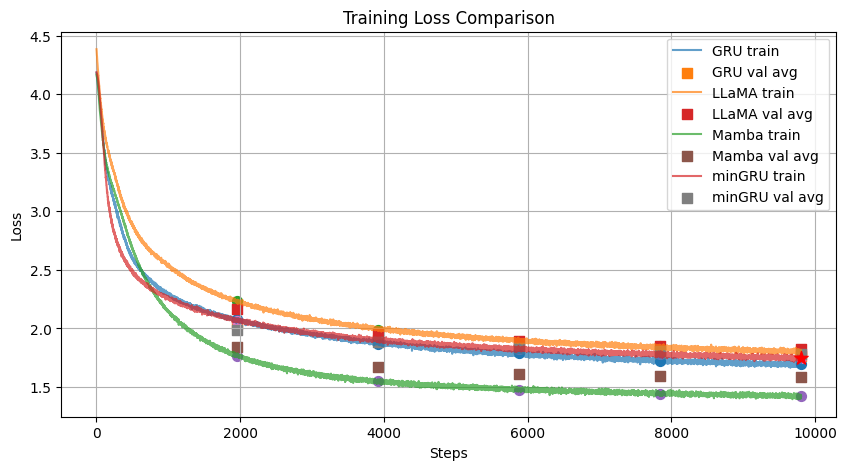

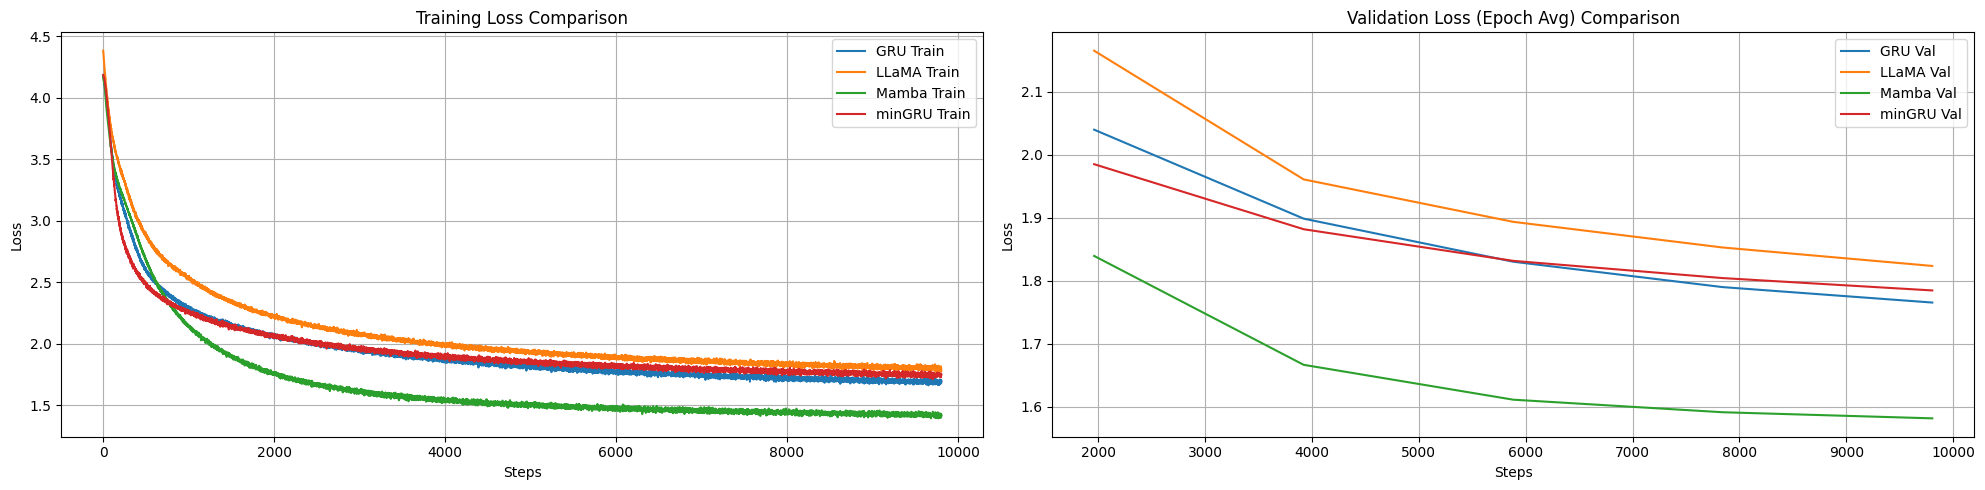

In [ ]:
train_and_test("minGRU", mingru, start_text)

In [ ]:
import io

def count_params(m): return sum(p.numel() for p in m.parameters())
def model_size_kb(m):
    buf=io.BytesIO(); torch.save(m.state_dict(),buf)
    return round(len(buf.getvalue())/1024)
def measure_time_ms(m,inp,iters=20):
    m.eval()
    with torch.no_grad():
        for _ in range(5): m(inp)
        ts=[]
        for _ in range(iters):
            t0=time.time(); m(inp); ts.append((time.time()-t0)*1000)
    return sum(ts)/len(ts)

# settings
device='cuda'

models={
    "Transformer":llama,
    "Mamba": mamba,
    "GRU": gru,
    "MinGRU": mingru
}

# 1) fixed length
inputs=torch.randint(vocab_size,(BATCH_SIZE,SEQUENCE_LENGTH),dtype=torch.long,device=device)
records=[]
for name,m in models.items():
    records.append({
        "Model": name,
        "Params": count_params(m),
        "Size_KB": model_size_kb(m),
        "Time_512_ms": round(measure_time_ms(m,inputs), 2)
    })
df_fixed=pd.DataFrame(records).set_index("Model")

# 2) speed vs length
seq_lens=[128,256,512,768,1024]
speed_data={name:[round(measure_time_ms(m,torch.randint(vocab_size,(BATCH_SIZE,L),dtype=torch.long,device=device)), 2) for L in seq_lens]
            for name,m in models.items()}
df_speed=pd.DataFrame(speed_data,index=seq_lens)
df_speed.index.name="Seq_Len"


In [ ]:
print("=== Comparison ===")
display(df_fixed)

=== Comparison ===


,Params,Size_KB,Time_512_ms
Model,,,
Transformer,37104,153,5.22
Mamba,99200,395,1.34
GRU,62689,250,23.76
MinGRU,120673,480,2.61


In [ ]:
display(df_speed)

,Transformer,Mamba,GRU,MinGRU
Seq_Len,,,,
128,8.44,8.91,47.51,6.01
256,23.64,8.03,94.36,14.80
512,79.47,16.60,189.98,29.06
768,174.84,30.05,288.95,45.57
1024,302.45,45.58,389.80,63.02


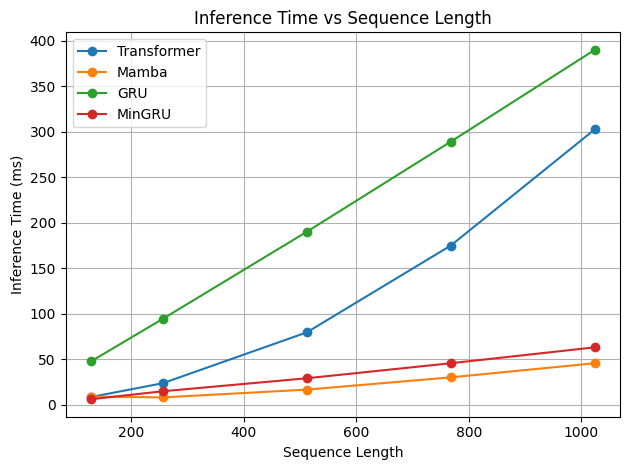

In [ ]:
import matplotlib.pyplot as plt

# df_speed: DataFrame with index=sequence lengths and columns=model names, values=time in ms
plt.figure()
for model in df_speed.columns:
    plt.plot(df_speed.index, df_speed[model], marker='o', label=model)
plt.xlabel("Sequence Length")
plt.ylabel("Inference Time (ms)")
plt.title("Inference Time vs Sequence Length")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
